In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## FEM PDE Solver 

### 1-D Solver

#### $L^2$ Projection

In [2]:
L = 1.0
N = 5


def u0(x):
    return 0


def uL(x):
    return 1


x = np.linspace(0, L, N)

In [3]:
def MassAssembler1D(x):
    h = x[1:] - x[:-1]
    d = np.concat([np.zeros((1,)), h]) + np.concat([h, np.zeros((1,))])
    MD = np.diag(d / 3.0) + np.diag(h / 6.0, -1) + np.diag(h / 6.0, 1)
    return MD


def LoadAssembler1D(x, f):
    n = len(x) - 1
    b = np.zeros((n + 1,))
    h = x[1:] - x[:-1]
    d = np.concat([np.zeros((1,)), h]) + np.concat([h, np.zeros((1,))])
    b = f(x) * (d) / 2.0
    return b


def L2Projector1D(x, f):
    M = MassAssembler1D(x)
    b = LoadAssembler1D(x, f)
    Pf = np.linalg.solve(M, b)
    return Pf


def StiffnessAssembler1D(x, a, kappa):
    h = x[1:] - x[:-1]
    mid = (x[1:] + x[:-1]) / 2.0
    d = np.concat([np.zeros((1,)), a(mid) / h]) + np.concat(
        [a(mid) / h, np.zeros((1,))]
    )
    S = np.diag(d) - np.diag(a(mid) / h, -1) - np.diag(a(mid) / h, 1)
    S[0, 0] += kappa[0]
    S[-1, -1] += kappa[-1]
    return S


def SourceAssembler1D(x, f, kappa, g):
    b = LoadAssembler1D(x, f)
    b[0] += kappa[0] * g[0]
    b[-1] += kappa[1] * g[1]
    return b


def PoissonSolver1D(x, kappa, g, cond, source):
    A = StiffnessAssembler1D(x, cond, kappa)
    b = SourceAssembler1D(x, source, kappa, g)
    u = np.linalg.solve(A, b)
    return u


def RefinementLoop1D(x, f, alpha):
    h = x[1:] - x[:-1]
    a = f(x[:-1])
    b = f(x[1:])
    t = ((a**2.0 + b**2.0) * h) / 2.0
    eta = h * np.sqrt(np.abs(t))
    idx = np.where(eta > alpha * np.max(eta))[0] + 1
    x = np.insert(x, idx, (x[idx - 1] + x[idx]) / 2.0)
    return x


def AdaptivePoissonSolver1D(
    x, kappa, g, cond, source, alpha=0.9, max_n=1e2, max_iter=100
):
    A = StiffnessAssembler1D(x, cond, kappa)
    b = SourceAssembler1D(x, source, kappa, g)
    u = np.linalg.solve(A, b)
    i = 1
    while x.shape[0] < max_n and i < max_iter:
        x = RefinementLoop1D(x, source, alpha=alpha)
        A = StiffnessAssembler1D(x, cond, kappa)
        b = SourceAssembler1D(x, source, kappa, g)
        u = np.linalg.solve(A, b)
        i += 1
    return u, x

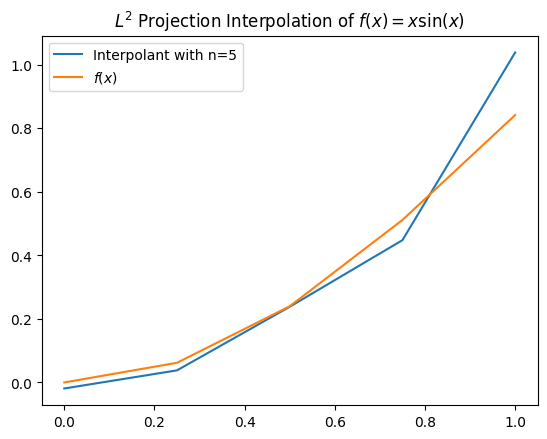

In [4]:
def f(x):
    return x * np.sin(x)


pf = L2Projector1D(x, f)
plt.plot(x, pf, label=f"Interpolant with n={len(x)}")
plt.plot(x, f(x), label=f"$f(x)$")
plt.legend()
plt.title("$L^2$ Projection Interpolation of $f(x) = x\\sin(x)$")
plt.show()

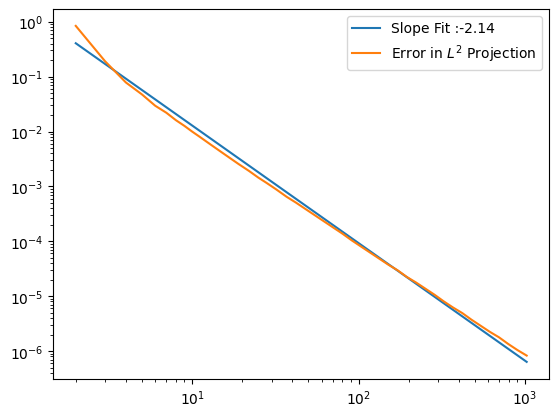

In [5]:
Ns = np.logspace(1, 10, 50, base=2, dtype=int)
errs = []
for n in Ns:
    x_conv = np.linspace(0, L, n)
    pf = L2Projector1D(x_conv, f)

    err = sp.integrate.simpson(np.abs(pf - f(x_conv)), x_conv)
    errs.append(err)

a, b = np.polyfit(np.log2(Ns), np.log2(errs), 1)
plt.loglog(Ns, 2 ** (a * np.log2(Ns) + b), label=f"Slope Fit :{a:.2f}")
plt.loglog(Ns, errs, label=f"Error in $L^2$ Projection")
plt.legend()
plt.show()

In [6]:
def make_u_h(xis, xs):
    xs = np.asarray(xs)
    xis = np.asarray(xis)

    def u_h(x):
        # Ensure array for vectorization
        x = np.asarray(x)

        # Find interval indices: i s.t. xs[i] <= x < xs[i+1]
        i = np.searchsorted(xs, x) - 1

        # clamp at boundaries
        i = np.clip(i, 0, len(xs) - 2)

        x0 = xs[i]
        x1 = xs[i + 1]
        u0 = xis[i]
        u1 = xis[i + 1]

        # linear interpolation
        t = (x - x0) / (x1 - x0)
        return u0 * (1 - t) + u1 * t

    return u_h

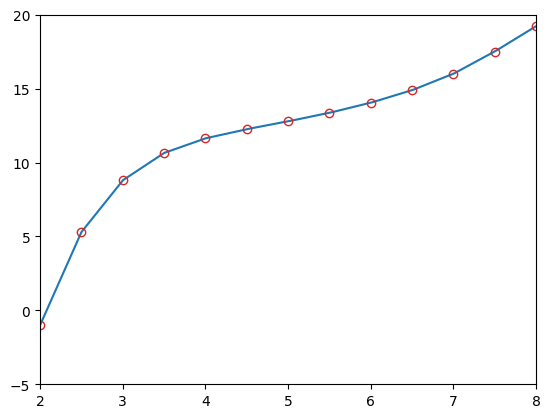

In [7]:
a, b = 2.0, 8.0
h = 0.5
N = int((b - a) // (h))
N_EVAL = 1000
KAPPA = np.array([1e6, 0.0])
G = np.array([-1, 0])


x = np.linspace(a, b, N + 1)


def conductivity(x):
    return (5 - 0.6 * x) * 0.1


def source(x):
    return 0.03 * (x - 6.0) ** 4.0


u = PoissonSolver1D(x, KAPPA, G, conductivity, source)
u_h = make_u_h(u, x)
x_eval = np.linspace(a, b, N_EVAL)
plt.plot(x_eval, u_h(x_eval))
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")

plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.show()

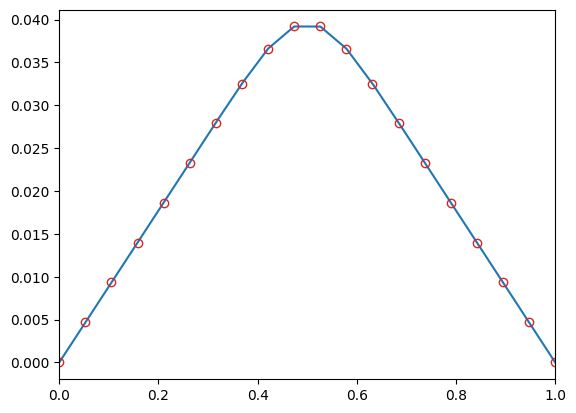

In [8]:
a, b = 0.0, 1.0
h = 0.05
N = int((b - a) // h)
KAPPA = np.array([1e6, 1e6])
N_EVAL = 1000
G = np.array(
    [
        0.0,
        0.0,
    ]
)

x = np.linspace(a, b, N + 1)


def conductivity(x):
    return 1.0


def source(x):
    return np.exp(-100.0 * ((x - 0.5) ** 2.0))


u = PoissonSolver1D(x, KAPPA, G, conductivity, source)
u_h = make_u_h(u, x)
x_eval = np.linspace(a, b, N_EVAL)
plt.plot(x_eval, u_h(x_eval))
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")
# plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.show()

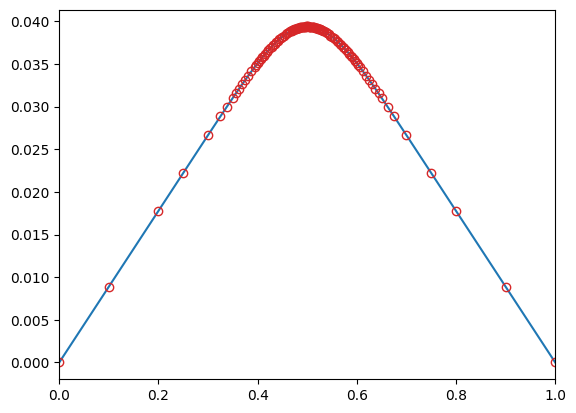

In [9]:
a, b = 0.0, 1.0
h = 0.01
N = 10
KAPPA = np.array([1e6, 1e6])
G = np.array(
    [
        0.0,
        0.0,
    ]
)

x = np.linspace(a, b, N + 1)


def conductivity(x):
    return 1


def source(x):
    return np.exp(-100.0 * ((x - 0.5) ** 2.0))


u, x = AdaptivePoissonSolver1D(
    x, KAPPA, G, conductivity, source, max_n=100, max_iter=25
)
plt.plot(x, u)
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")
# plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.show()